<h1>Imports</h1>

In [1]:
from read_data import read_dataset_1, translate_1
from models import SimulationEnvironment
from optimizer import BaseGA
from visualize import reformat_result, visualize, visualize_schedule, fitness_history_plot
import random

<h1>Parameters</h1>

In [2]:
# general parameters
order_amount = 10
earliest_time_slot = 0
last_time_slot = 5000

<h1>Input</h1>

In [3]:
input, orders, instance = read_dataset_1(use_instance=13, order_amount=order_amount, earliest_time=earliest_time_slot, last_time=last_time_slot)
recipes, workstations, resources, tasks, orders_model = translate_1(instance, orders, earliest_time_slot, last_time_slot)
env = SimulationEnvironment(workstations, tasks, resources, recipes)

<h1>Experiments</h1>

Makespan Evaluation

Current generation: 0, Current Best: 10076, not feasible
Current generation: 1, Current Best: 10076, not feasible
Current generation: 2, Current Best: 10051, not feasible
Current generation: 3, Current Best: 10003, not feasible
Current generation: 4, Current Best: 10003, not feasible
Current generation: 5, Current Best: 9977, not feasible
Current generation: 6, Current Best: 9961, not feasible
Current generation: 7, Current Best: 9956, not feasible
Current generation: 8, Current Best: 9952, not feasible
Current generation: 9, Current Best: 9924, not feasible
Current generation: 10, Current Best: 9924, not feasible
Current generation: 11, Current Best: 9892, not feasible
Current generation: 12, Current Best: 9889, not feasible
Current generation: 13, Current Best: 9889, not feasible
Current generation: 14, Current Best: 9889, not feasible
Current generation: 15, Current Best: 9871, not feasible
Current generation: 16, Current Best: 9871, not feasible
Current generation: 17, Current Best

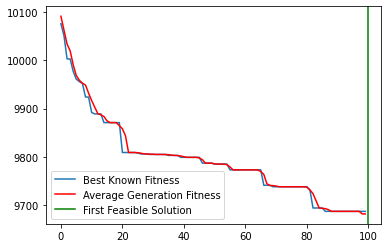

In [11]:
max_generations = 100
population_size = 10
offspring_amount = 20

optimizer = BaseGA(env)
optimizer.set_minimize()
optimizer.configure('makespan', 'twopointcrossover', 'roulettewheel', 'randomize')
last_time_slot = 5000
# set all delivery dates to last time slot
for order in orders:
    order[1] = last_time_slot
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

Current generation: 0, Current Best: 98269, not feasible
Current generation: 1, Current Best: 98269, not feasible
Current generation: 2, Current Best: 98269, not feasible
Current generation: 3, Current Best: 98269, not feasible
Current generation: 4, Current Best: 98269, not feasible
Current generation: 5, Current Best: 98269, not feasible
Current generation: 6, Current Best: 98269, not feasible
Current generation: 7, Current Best: 98269, not feasible
Current generation: 8, Current Best: 98269, not feasible
Current generation: 9, Current Best: 98244, not feasible
Current generation: 10, Current Best: 98244, not feasible
Current generation: 11, Current Best: 98244, not feasible
Current generation: 12, Current Best: 98244, not feasible
Current generation: 13, Current Best: 98244, not feasible
Current generation: 14, Current Best: 98244, not feasible
Current generation: 15, Current Best: 98244, not feasible
Current generation: 16, Current Best: 98244, not feasible
Current generation: 17, 

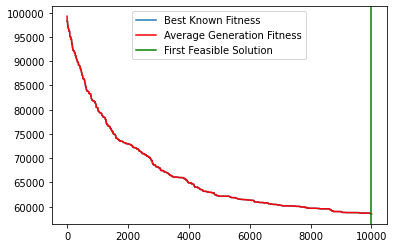

In [12]:
max_generations = 10000
population_size = 10
offspring_amount = 20
earliest_time_slot = 0
last_time_slot = 50000

optimizer = BaseGA(env)
optimizer.set_minimize()
optimizer.configure('makespan', 'twopointcrossover', 'roulettewheel', 'randomize')
# set all delivery dates to last time slot
for order in orders:
    order[1] = last_time_slot
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

<h3>Testing pygad</h3>

In [24]:
import pygad

pygad helper functions

In [10]:
def reformat_pygad_result(solution, orders, environment):
    j = 0
    result = []
    for i in range(len(solution)):
        if j == 0:
            result.append([])
        result[len(result)-1].append(solution[i])
        j += 1
        if j > 2:
            j = 0
    workstation_assignments = dict()
    for i in range(len(result)):
        operation = result[i]
        if operation[1] not in workstation_assignments:
            workstation_assignments[operation[1]] = []
        _, order = map_index_to_operation(i, orders, environment)
        workstation_assignments[operation[1]].append([order[2], order[0], i, operation[0], operation[2], environment.get_duration(operation[0], operation[1])])
    return workstation_assignments

Parameters of the best solution : [  76    6  249   55    6 1522   57    6  480  108    6 4671   68    6
 1580    4    4  965   76    6  938  106    6 2141   25    3 3469   36
    6 2146   74    6  397  104    6   72  136    6 2618  133    6 4684
   58    6  728  108    6 3584   37    6  671  116    6 1561  108    6
  266  129    6  616    3    2  400  137    6 2891  134    6 4085   90
    6 3377   59    6  216   64    6 3686   55    6 2366   31    3 3415
    4    4 4986  138    6  537]
Fitness value of the best solution = 10000


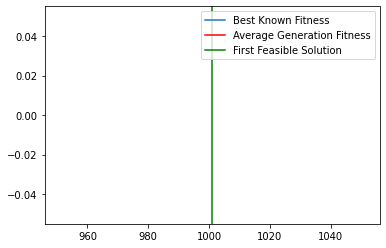

In [11]:
from optimizer_components import map_index_to_operation

earliest_time_slot = 0
last_time_slot = 5000

def feasible(solution):
    j = 0
    for i in range(len(solution)):
        if j == 2:
            # just check if task and workstation do exist
            """if env.get_task(solution[i-2]) is None or env.get_workstation(solution[i-1]) is None:
                return False"""
            if solution[i] < earliest_time_slot:
                return False
            duration = env.get_duration(solution[i-2], solution[i-1])
            if duration == 0: # illegal combination
                return False
            if solution[i] + duration > last_time_slot:
                return False
        j += 1
        if j > 2:
            j = 0
    return True # just testing

def fitness_function(solution, solution_idx):
    fitness = 0
    if feasible(solution):
        min = float('inf')
        max = -float('inf')
        i = 0
        for gene in solution:
            if i == 2:
                if gene < min:
                    min = gene
                duration = env.get_duration(solution[i-2], solution[i-1])
                if gene + duration > max:
                    max = gene + duration
            i += 1
            if i > 2:
                i = 0
        fitness += abs(max - min)
    else:
        fitness = 2 * last_time_slot
    return fitness

def only_valid_mutation_function(offsprings, ga_instance):
    start_low = ga_instance.gene_space[2]['low']
    start_high = ga_instance.gene_space[2]['high']
    
    for offspring in offsprings:
        j = 0
        for i in range(len(offspring)):
            if j == 0:
                valid_workstations = env.get_valid_workstations(offspring[i])
            if random.random() < 1/len(offspring): # just fix mutation probability for now
                if j == 1:
                    offspring[i] = random.choice(valid_workstations).id
                elif j == 2:
                    offspring[i] = random.randint(start_low, start_high)
            j += 1
            if j > 2:
                j = 0
    return offsprings

def mutation_function(offsprings, ga_instance):
    workstation_low = ga_instance.gene_space[1]['low']
    workstation_high = ga_instance.gene_space[1]['high']
    start_low = ga_instance.gene_space[2]['low']
    start_high = ga_instance.gene_space[2]['high']
    
    for offspring in offsprings:
        j = 0
        for i in range(len(offspring)):
            if random.random() < 1/len(offspring): # just fix mutation probability for now
                if j == 1:
                    offspring[i] = random.randint(workstation_low, workstation_high)
                elif j == 2:
                    offspring[i] = random.randint(start_low, start_high)
            j += 1
            if j > 2:
                j = 0
    return offsprings

flat_input = [item for sublist in input for item in sublist]
num_genes = len(flat_input)
num_generations = 1000
num_parents_mating = 25
sol_per_pop = 50
init_range_low = 0
init_range_high = last_time_slot
parent_selection_type = 'rws'
keep_parents = 1
crossover_type = 'single_point'
#mutation_type = 'random'
#mutation_type = mutation_function
mutation_type = only_valid_mutation_function
mutation_percentage_genes = 10
fitness_func = fitness_function
gene_type = int
gene_space = []
space_tasks = {'low': 0, 'high': len(tasks)-1}#[0, len(tasks)-1]
space_workstations = {'low': 1, 'high': len(workstations)-1}#[0, len(workstations)-1]
space_time = {'low': earliest_time_slot, 'high': last_time_slot}#[earliest_time_slot, last_time_slot]
j = 0
for i in range(num_genes):
    if j == 0:
        gene_space.append(space_tasks)
    elif j == 1:
        gene_space.append(space_workstations)
    else:
        gene_space.append(space_time)
    j += 1
    if j > 2:
        j = 0
ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_func, sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high, parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type, mutation_type=mutation_type, mutation_percent_genes=mutation_percentage_genes, gene_type=gene_type, gene_space=gene_space)
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

workstation_assignments = reformat_pygad_result(solution, orders, env)
visualize(workstation_assignments, [], [], [], num_generations+1)

Parameters of the best solution : [  99    6 1841   58    6 4754  111    6 1557    7    4 3212   98    6
  735   91    6 4937    8    4  703   54    6 4230  102    6 4259   68
    6 1040   97    6 1575   61    6 2052  104    6 3518   98    6 1656
   88    6 4308  126    6 4176   10    7 1800   11    7  322  102    6
 3433   72    6 2755  138    6 3161  118    6 3927   99    6  500   68
    6 4959   45    6 3027   53    6 4799  125    6 4443   20    5 1140
    8    4 4009   65    6 1014]
Fitness value of the best solution = 10000


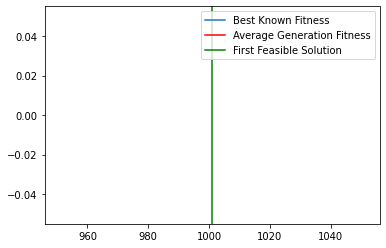

In [12]:
earliest_time_slot = 0
last_time_slot = 5000
operations = []

def get_alternative_tasks(task_id):
    task = env.get_task(task_id)
    tasks = env.tasks
    alternatives = []
    for t in tasks:
        if task.result_resources[0][0] == t.result_resources[0][0] and t not in alternatives and t.id != task_id:
            alternatives.append(t)
    return alternatives

def mutation_function(offsprings, ga_instance):
    for offspring in offsprings:
        for i in range(len(operations)):
            if random.random() < 1 / len(operations):
                task = offspring[i*3]
                alternatives = get_alternative_tasks(task)
                offspring[i*3] = random.choice(alternatives).id
                offspring[i*3+1] = random.choice(env.get_valid_workstations(offspring[i*3])).id
                offspring[i*3+2] = random.randint(earliest_time_slot, last_time_slot)
    return offsprings

def fitness_function(solution, solution_idx):
    fitness = 0
    if feasible(solution):
        min = float('inf')
        max = -float('inf')
        i = 0
        for gene in solution:
            if i == 2:
                if gene < min:
                    min = gene
                duration = env.get_duration(solution[i-2], solution[i-1])
                if gene + duration > max:
                    max = gene + duration
            i += 1
            if i > 2:
                i = 0
        fitness += abs(max - min)
    else:
        fitness = 2 * last_time_slot
    return fitness

for order in orders_model:
    for resource in order.resources:
        recipe = resource.recipes[0] # just use recipe 0 for now
        recipe_tasks = env.get_all_tasks_for_recipe(recipe.id)
        results = dict()
        for task in recipe_tasks:
            if task.result_resources[0][0] not in results:
                results[task.result_resources[0][0]] = []
            results[task.result_resources[0][0]].append(task)
        for key in results:
            operations.append(random.choice(results[key]).id)
assignments = []
for operation in operations:
    workstation = env.get_valid_workstations(operation)
    assignments.append(operation)
    assignments.append(random.choice(workstation).id)
    assignments.append(random.randint(earliest_time_slot, last_time_slot))

num_genes = len(assignments)
num_generations = 1000
num_parents_mating = 25
sol_per_pop = 50
init_range_low = 0
init_range_high = last_time_slot
parent_selection_type = 'rws'
keep_parents = 1
crossover_type = 'two_points'
mutation_type = mutation_function
mutation_percentage_genes = 10
fitness_func = fitness_function
gene_type = int
ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_func, sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high, parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type, mutation_type=mutation_type, mutation_percent_genes=mutation_percentage_genes, gene_type=gene_type, gene_space=gene_space)
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

workstation_assignments = reformat_pygad_result(solution, orders, env)
visualize(workstation_assignments, [], [], [], num_generations+1)

Testing DEAP

In [22]:
from deap import creator, base, tools, algorithms

In [23]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return sum(individual),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=300)

NGEN=40
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
top10 = tools.selBest(population, k=10)
print(top10[0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
